In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
def draw_rosenbrock(a, b, levels):
    
    rosenbrockfunction = lambda x1, x2: (a-x1)**2 + b*(x2 - x1**2)**2
    
    X1, X2 = np.meshgrid(np.linspace(-2.0, 2.0, 400), np.linspace(-2.0, 2.0, 400))
    Y = rosenbrockfunction(X1, X2)
    
    plt.figure(figsize=(8, 8))
    plt.contour(X1, X2, Y, np.logspace(-2.0, 2.0, levels, base=10))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

In [4]:
# Gradient Descent

import numpy as np

# Algorithm 4.3: p.62
def strong_backtracking(f, grads, x, d, alpha = 1.0, beta = 1E-4, sigma = 1E-1, verbose = False):
    
    y0, g0, y_prev, alpha_prev = f(x), np.dot(grads(x), d), np.nan, 0.0
    alpha_lo, alpha_hi = np.nan, np.nan

    # bracket phase
    while True:
        
        y = f(x + alpha * d)
        
        if y > y0 + beta * alpha * g0 or (not(np.isnan(y_prev)) and y >= y_prev):
            alpha_lo, alpha_hi = alpha_prev, alpha
            break
        
        g = np.dot(grads(x + alpha * d), d)
        
        if np.abs(g) <= -sigma * g0:
            return alpha
        elif g >= 0:
            alpha_lo, alpha_hi = alpha, alpha_prev
            break
        
        y_prev, alpha_prev, alpha = y, alpha, 2 * alpha
        
    if verbose:
        print('backtracking: alpha %.4f, y %.4f' % (alpha, y))
    
    # zoom phase
    y_lo = f(x + alpha_lo * d)
    
    while True:

        alpha = 0.5 * (alpha_lo + alpha_hi)
        y = f(x + alpha * d)
        
        if (y > y0 + beta * alpha * g0 ) or (y >= y_lo):
            alpha_hi = alpha
        else:
            g = np.dot(grads(x + alpha * d), d)
            
            #print(abs(g), -sigma * g0)
            
            if abs(g) <= -sigma * g0:
                return alpha
            elif g * (alpha_hi - alpha_lo) >= 0.0:
                alpha_hi = alpha_lo
            
            alpha_lo = alpha

            
def GradientDescent(f, grads, x, alpha, maxiter = 1000, TOL = 1E-4, verbose = False):
    
    y_prev = f(x)
    
    flag = True
    i = 1
    
    while flag:
        
        g = np.asarray(grads(x))
        g = g / np.sqrt(np.dot(g, g))
        
        x = x + alpha * (-1 * g)
        
        y = f(x)

        if verbose:
            print('{}: y {:.4f}, x {}'.format(i, y, x))
        
        if abs(y_prev - y) < TOL * (abs(y_prev) + TOL) or i >= maxiter:
            
            flag = False
        
        y_prev = y
        
        i += 1
        
    return i, y, x
        
    

def ConjugateGradient(f, grads, x, method = 'FL', maxiter = 1000, TOL = 1E-4, verbose = False):
    
    y_prev = f(x)
    g_prev = np.asarray(grads(x))
    d = -1 * g_prev
    
    alpha =  strong_backtracking(f, grads, x, d, 1)
    x = x + alpha * d
    
    i = 1
    flag = True
    while flag:
        
        g = np.asarray(grads(x))
        
        if method == 'FL':
            beta = (np.dot(g, g)) / (np.dot(g_prev, g_prev)) # Fletcher_Reeves
        elif method == 'PR':
            beta = (np.dot(g, (g - g_prev))) / (np.dot(g_prev, g_prev)) # Polak-Ribiere
            beta = np.max(beta, 0)
        else:
            beta = (np.dot(g, g)) / (np.dot(g_prev, g_prev)) # Fletcher_Reeves
            
        d = - g + beta * d
        
        alpha =  strong_backtracking(f, grads, x, d, 1)

        x = x + alpha * d
        y = f(x)

        if verbose:
             print('{}: y {:.4f}, x {}'.format(i, y, x))
        
        if np.abs(y - y_prev) < TOL * (np.abs(y_prev) + TOL) or i >= maxiter:
            
            flag = False
        
        y_prev = y
        g_prev = g
        
        i += 1
        
    return i, y, x


""" Momentum """
def momentum(f, grads, x, alpha, beta = 0.9, maxiter = 1000, TOL = 1E-4, verbose = True):
    
    v = -alpha * np.asarray(grads(x))
    x = x + v
    
    y_prev = f(x)
    
    
    flag = True
    i = 1
    while flag:
        
        v = beta * v - alpha * np.asarray(grads(x))
        x = x + v
        
        y = f(x)

        if verbose:
             print('{}: y {:.4f}, x {}'.format(i, y, x))
        
        if abs(y_prev - y) < TOL * (abs(y_prev) + TOL) or i >= maxiter:
            
            flag = False
        
        y_prev = y
        
        i += 1
        
    return i, y, x
        

""" Nesterov (1983) """
def nesterov(f, grads, x, alpha, beta = 0.9, maxiter = 1000, TOL = 1E-4, verbose = True):
    
    v = -alpha * np.asarray(grads(x))
    x = x + v
    
    y_prev = f(x)
    
    
    flag = True
    i = 1
    while flag:
        
        v = beta * v - alpha * np.asarray(grads(x + beta * v))
        x = x + v
        
        y = f(x)

        if verbose:
             print('{}: y {:.4f}, x {}'.format(i, y, x))
        
        if abs(y_prev - y) < TOL * (abs(y_prev) + TOL) or i >= maxiter:
            
            flag = False
        
        y_prev = y
        
        i += 1
        
    return i, y, x
        

""" Adagrad: Adaptive subgradient (2011) """
def adagrad(f, grads, x, alpha, epsilon = 1E-7, maxiter = 1000, TOL = 1E-4, verbose = True):

    s = np.zeros_like(x)

    y_prev = f(x)
  
    flag = True
    i = 1
    while flag:
        
        g = np.asarray(grads(x))
        s += (g * g)

        x = x - alpha * g / np.sqrt(s + epsilon)

        y = f(x) 
        
        if verbose:
             print('{}: y {:.4f}, x {}'.format(i, y, x))
        
        if abs(y_prev - y) < TOL * (abs(y_prev) + TOL) or i >= maxiter:
            
            flag = False
        
        y_prev = y
        
        i += 1
        
    return i, y, x
        
      

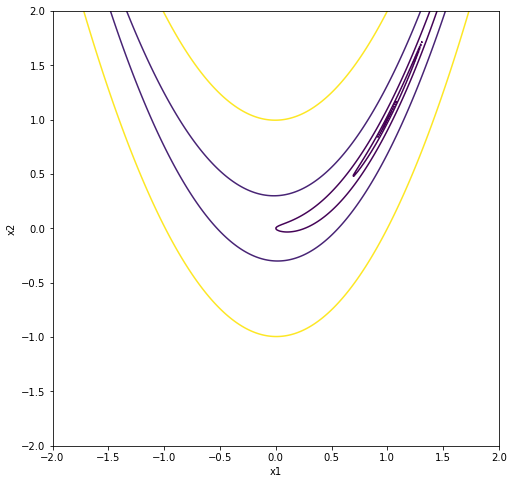

In [3]:
draw_rosenbrock(1, 100, 5)

In [13]:
def f(x, a=1, b=100):
    y = (a - x[0])**2 + b*(x[1] - x[0]**2)**2
    return y

In [14]:
x = sp.IndexedBase('x')
gradients = np.array([sp.diff(f(x), x[i]) for i in range(2)])
grads = sp.lambdify(x, gradients, 'numpy')

In [15]:
x_ = np.array([-2., 2.])

In [18]:
GradientDescent(f, grads, x_, alpha=1e-1, verbose=True)

1: y 263.5018, x [-1.90296446  2.02416825]
2: y 155.0008, x [-1.80621763  2.04946746]
3: y 79.1555, x [-1.70979857  2.07598849]
4: y 31.8685, x [-1.61374854  2.10381638]
5: y 9.2866, x [-1.51809595  2.13298112]
6: y 7.7987, x [-1.42269365  2.16295446]
7: y 9.2702, x [-1.51634513  2.12789166]
8: y 7.7873, x [-1.42095203  2.15789428]
9: y 9.2537, x [-1.51458843  2.12279122]
10: y 7.7758, x [-1.41920459  2.15282327]
11: y 9.2371, x [-1.51282581  2.11767972]
12: y 7.7643, x [-1.41745129  2.14774135]
13: y 9.2205, x [-1.51105721  2.1125571 ]
14: y 7.7528, x [-1.41569207  2.14264847]
15: y 9.2039, x [-1.5092826   2.10742328]
16: y 7.7413, x [-1.4139269   2.13754454]
17: y 9.1872, x [-1.50750192  2.1022782 ]
18: y 7.7297, x [-1.41215572  2.13242951]
19: y 9.1705, x [-1.50571513  2.09712178]
20: y 7.7181, x [-1.41037848  2.12730329]
21: y 9.1538, x [-1.50392218  2.09195394]
22: y 7.7064, x [-1.40859515  2.12216582]
23: y 9.1370, x [-1.50212302  2.08677461]
24: y 7.6948, x [-1.40680568  2.11701

364: y 4.8389, x [-0.92033425  0.9543096 ]
365: y 5.2192, x [-1.00601555  0.90274687]
366: y 4.8111, x [-0.91501066  0.94419695]
367: y 5.1837, x [-1.00054392  0.89238903]
368: y 4.7831, x [-0.90961351  0.93400226]
369: y 5.1479, x [-0.99499452  0.88194379]
370: y 4.7547, x [-0.90414053  0.9237236 ]
371: y 5.1118, x [-0.98936484  0.87140902]
372: y 4.7260, x [-0.89858929  0.91335898]
373: y 5.0753, x [-0.98365229  0.8607825 ]
374: y 4.6970, x [-0.89295728  0.90290631]
375: y 5.0384, x [-0.97785412  0.85006193]
376: y 4.6677, x [-0.88724185  0.89236344]
377: y 5.0012, x [-0.97196742  0.83924492]
378: y 4.6379, x [-0.88144021  0.88172813]
379: y 4.9635, x [-0.96598918  0.82832896]
380: y 4.6079, x [-0.87554942  0.87099804]
381: y 4.9255, x [-0.95991618  0.81731145]
382: y 4.5774, x [-0.86956641  0.86017075]
383: y 4.8871, x [-0.95374505  0.80618967]
384: y 4.5466, x [-0.86348793  0.84924373]
385: y 4.8483, x [-0.94747223  0.7949608 ]
386: y 4.5153, x [-0.85731054  0.83821434]
387: y 4.80

561: y 0.7671, x [0.43031425 0.11864744]
562: y 0.7761, x [0.36905753 0.19768929]
563: y 0.7659, x [0.43340953 0.12114637]
564: y 0.7750, x [0.37181482 0.19992511]
565: y 0.7648, x [0.43637893 0.12356102]
566: y 0.7740, x [0.37446325 0.20208776]
567: y 0.7637, x [0.43922985 0.12589531]
568: y 0.7731, x [0.37700902 0.20418049]
569: y 0.7628, x [0.4419691  0.12815294]
570: y 0.7722, x [0.37945782 0.20620639]
571: y 0.7619, x [0.44460295 0.13033734]
572: y 0.7714, x [0.38181493 0.20816834]
573: y 0.7610, x [0.44713719 0.13245175]
574: y 0.7706, x [0.38408521 0.21006906]
575: y 0.7602, x [0.44957719 0.13449922]
576: y 0.7698, x [0.38627318 0.21191112]
577: y 0.7595, x [0.45192788 0.13648261]
578: y 0.7692, x [0.38838304 0.21369695]
579: y 0.7588, x [0.45419389 0.13840463]
580: y 0.7685, x [0.3904187  0.21542882]
581: y 0.7581, x [0.45637948 0.14026782]
582: y 0.7679, x [0.39238379 0.2171089 ]
583: y 0.7575, x [0.45848864 0.14207458]
584: y 0.7673, x [0.39428171 0.21873924]
585: y 0.7569, x

828: y 0.7571, x [0.45958754 0.27941675]
829: y 0.7464, x [0.53024226 0.20865016]
830: y 0.7571, x [0.45968423 0.27951316]
831: y 0.7464, x [0.53034499 0.20875259]
832: y 0.7571, x [0.45977894 0.2796076 ]
833: y 0.7464, x [0.53044561 0.20885295]
834: y 0.7571, x [0.45987171 0.27970014]
835: y 0.7464, x [0.53054417 0.20895126]
836: y 0.7571, x [0.45996258 0.27979079]
837: y 0.7464, x [0.53064072 0.20904759]
838: y 0.7571, x [0.46005159 0.27987961]
839: y 0.7464, x [0.53073529 0.20914196]
840: y 0.7571, x [0.46013879 0.27996663]
841: y 0.7464, x [0.53082792 0.20923442]
842: y 0.7571, x [0.4602242 0.2800519]
843: y 0.7464, x [0.53091867 0.20932501]
844: y 0.7571, x [0.46030788 0.28013543]
845: y 0.7464, x [0.53100756 0.20941376]
846: y 0.7571, x [0.46038985 0.28021728]
847: y 0.7464, x [0.53109464 0.20950072]
848: y 0.7571, x [0.46047014 0.28029747]
849: y 0.7464, x [0.53117995 0.20958592]
850: y 0.7571, x [0.46054881 0.28037605]
851: y 0.7464, x [0.53126351 0.2096694 ]
852: y 0.7571, x [

(1001, 0.7570692296140327, array([0.46354341, 0.28337677]))

In [19]:
ConjugateGradient(f, grads, x_)

(23, 6.591144046517935e-09, array([1.00008085, 1.00016244]))

In [29]:
momentum(f, grads, x_, alpha=7e-4, verbose=True)

1: y 515.0708, x [-0.2324115   2.32018359]
2: y 400.1298, x [0.2008921  2.03908523]
3: y 102.1132, x [0.7044121  1.50627485]
4: y 91.6558, x [1.35721714 0.88533452]
5: y 415.7241, x [1.58067421 0.46042677]
6: y 16.7570, x [0.87893058 0.36334437]
7: y 10.4433, x [0.14683271 0.33325466]
8: y 2.2651, x [-0.49804617  0.26253665]
9: y 97.6348, x [-1.07836011  0.1968623 ]
10: y 210.6078, x [-1.30605865  0.27299515]
11: y 22.0608, x [-0.98379119  0.54210587]
12: y 28.9763, x [-0.57369839  0.84390901]
13: y 94.2303, x [-0.28510353  1.04346276]
14: y 117.4797, x [-0.10037876  1.08835611]
15: y 96.2675, x [0.03710786 0.97780089]
16: y 51.3653, x [0.17233911 0.74160185]
17: y 10.7374, x [0.32955871 0.42935656]
18: y 2.4437, x [0.50159241 0.10343114]
19: y 33.0857, x [ 0.63631152 -0.16915881]
20: y 58.5162, x [ 0.65579078 -0.3341226 ]
21: y 43.8052, x [ 0.53348343 -0.37560424]
22: y 18.6385, x [ 0.32544101 -0.32050847]
23: y 5.7060, x [ 0.1002903  -0.21122344]
24: y 2.0985, x [-0.10729961 -0.08188

400: y 0.0530, x [0.77012091 0.59203121]
401: y 0.0525, x [0.77112181 0.59357904]
402: y 0.0520, x [0.77211639 0.59511907]
403: y 0.0516, x [0.7731047  0.59665134]
404: y 0.0511, x [0.77408681 0.59817592]
405: y 0.0507, x [0.77506276 0.59969287]
406: y 0.0503, x [0.77603264 0.60120224]
407: y 0.0498, x [0.77699648 0.60270409]
408: y 0.0494, x [0.77795436 0.60419848]
409: y 0.0490, x [0.77890633 0.60568546]
410: y 0.0486, x [0.77985244 0.60716509]
411: y 0.0482, x [0.78079276 0.60863742]
412: y 0.0477, x [0.78172733 0.6101025 ]
413: y 0.0473, x [0.78265621 0.61156039]
414: y 0.0469, x [0.78357946 0.61301114]
415: y 0.0465, x [0.78449712 0.6144548 ]
416: y 0.0461, x [0.78540925 0.61589143]
417: y 0.0458, x [0.7863159  0.61732107]
418: y 0.0454, x [0.78721712 0.61874377]
419: y 0.0450, x [0.78811297 0.62015959]
420: y 0.0446, x [0.78900348 0.62156857]
421: y 0.0442, x [0.78988871 0.62297076]
422: y 0.0439, x [0.79076871 0.62436621]
423: y 0.0435, x [0.79164352 0.62575497]
424: y 0.0431, x

756: y 0.0041, x [0.93614231 0.87609679]
757: y 0.0041, x [0.93634661 0.87648024]
758: y 0.0040, x [0.93655019 0.8768624 ]
759: y 0.0040, x [0.93675305 0.87724329]
760: y 0.0040, x [0.93695519 0.87762291]
761: y 0.0040, x [0.93715661 0.87800126]
762: y 0.0039, x [0.93735731 0.87837835]
763: y 0.0039, x [0.93755731 0.87875419]
764: y 0.0039, x [0.9377566  0.87912877]
765: y 0.0039, x [0.93795518 0.87950211]
766: y 0.0038, x [0.93815306 0.87987421]
767: y 0.0038, x [0.93835024 0.88024507]
768: y 0.0038, x [0.93854673 0.8806147 ]
769: y 0.0038, x [0.93874252 0.88098311]
770: y 0.0037, x [0.93893762 0.88135029]
771: y 0.0037, x [0.93913204 0.88171625]
772: y 0.0037, x [0.93932577 0.882081  ]
773: y 0.0037, x [0.93951882 0.88244454]
774: y 0.0036, x [0.93971119 0.88280687]
775: y 0.0036, x [0.93990288 0.88316801]
776: y 0.0036, x [0.9400939  0.88352795]
777: y 0.0036, x [0.94028425 0.8838867 ]
778: y 0.0035, x [0.94047393 0.88424426]
779: y 0.0035, x [0.94066295 0.88460064]
780: y 0.0035, x

(1001, 0.0008995599973970791, array([0.97003221, 0.94084036]))

In [28]:
nesterov(f, grads, x_, alpha=7e-4, verbose=True)

1: y 452.5212, x [0.23288999 2.18010868]
2: y 0.2838, x [1.42872439 2.00962851]
3: y 451.6260, x [-0.59638087  2.47481508]
4: y 987.2616, x [-0.41072382  3.30759738]
5: y 1047.2630, x [-0.5146059  3.4974172]
6: y 344.5391, x [-1.16747206  3.20646927]
7: y 8.7906, x [-1.68456365  2.96359874]
8: y 394.7865, x [-1.01545828  3.00783067]
9: y 440.3044, x [-0.74417634  2.64488002]
10: y 201.5951, x [-0.78748391  2.02867618]
11: y 16.2341, x [-1.00696102  1.36334496]
12: y 4.5240, x [-0.9699612   0.86062192]
13: y 6.6544, x [-0.81090483  0.47385404]
14: y 6.4244, x [-0.60556368  0.17058151]
15: y 6.4204, x [-0.38585097 -0.06324778]
16: y 8.0971, x [-0.17016675 -0.23042303]
17: y 11.7131, x [ 0.02275758 -0.32747715]
18: y 15.2110, x [ 0.17258279 -0.35135061]
19: y 14.9240, x [ 0.26816624 -0.30740812]
20: y 10.2464, x [ 0.31608939 -0.21279628]
21: y 4.5830, x [ 0.33429953 -0.09170976]
22: y 1.1457, x [0.34121729 0.03206813]
23: y 0.4520, x [0.35057021 0.14028304]
24: y 1.1173, x [0.37082188 0.2

342: y 0.0045, x [0.93274408 0.86973127]
343: y 0.0045, x [0.93295985 0.87013477]
344: y 0.0045, x [0.93317484 0.87053691]
345: y 0.0044, x [0.93338907 0.87093771]
346: y 0.0044, x [0.93360253 0.87133716]
347: y 0.0044, x [0.93381523 0.87173528]
348: y 0.0044, x [0.93402717 0.87213206]
349: y 0.0043, x [0.93423835 0.87252752]
350: y 0.0043, x [0.93444878 0.87292166]
351: y 0.0043, x [0.93465846 0.87331448]
352: y 0.0042, x [0.93486739 0.87370599]
353: y 0.0042, x [0.93507558 0.87409619]
354: y 0.0042, x [0.93528303 0.87448509]
355: y 0.0042, x [0.93548974 0.87487269]
356: y 0.0041, x [0.93569572 0.875259  ]
357: y 0.0041, x [0.93590096 0.87564403]
358: y 0.0041, x [0.93610548 0.87602777]
359: y 0.0041, x [0.93630927 0.87641023]
360: y 0.0040, x [0.93651235 0.87679143]
361: y 0.0040, x [0.9367147  0.87717135]
362: y 0.0040, x [0.93691634 0.87755002]
363: y 0.0040, x [0.93711726 0.87792742]
364: y 0.0039, x [0.93731748 0.87830358]
365: y 0.0039, x [0.93751699 0.87867848]
366: y 0.0039, x

686: y 0.0005, x [0.97663748 0.95372596]
687: y 0.0005, x [0.97670701 0.95386206]
688: y 0.0005, x [0.97677633 0.95399775]
689: y 0.0005, x [0.97684543 0.95413303]
690: y 0.0005, x [0.97691431 0.9542679 ]
691: y 0.0005, x [0.97698299 0.95440237]
692: y 0.0005, x [0.97705145 0.95453643]
693: y 0.0005, x [0.9771197  0.95467008]
694: y 0.0005, x [0.97718774 0.95480333]
695: y 0.0005, x [0.97725557 0.95493618]
696: y 0.0005, x [0.97732319 0.95506863]
697: y 0.0005, x [0.9773906  0.95520067]
698: y 0.0005, x [0.97745781 0.95533232]
699: y 0.0005, x [0.9775248  0.95546358]
700: y 0.0005, x [0.97759159 0.95559443]
701: y 0.0005, x [0.97765818 0.95572489]
702: y 0.0005, x [0.97772455 0.95585496]
703: y 0.0005, x [0.97779073 0.95598464]
704: y 0.0005, x [0.9778567  0.95611392]
705: y 0.0005, x [0.97792246 0.95624282]
706: y 0.0005, x [0.97798803 0.95637132]
707: y 0.0005, x [0.97805339 0.95649944]
708: y 0.0005, x [0.97811855 0.95662718]
709: y 0.0005, x [0.97818351 0.95675452]
710: y 0.0005, x

(1001, 8.626182688784772e-05, array([0.99071979, 0.98148835]))

In [35]:
adagrad(f, grads, x_, alpha=3.05e-0, verbose=True)

1: y 1558.2781, x [1.05 5.05]
2: y 6684.1733, x [3.24066054 2.32927236]
3: y 2444.3282, x [0.26051767 5.01133118]
4: y 1166.2279, x [0.40562206 3.57901985]
5: y 539.7595, x [0.56135435 2.63797699]
6: y 228.2622, x [0.70773686 2.01144371]
7: y 85.1561, x [0.82762178 1.60759717]
8: y 27.8652, x [0.91319671 1.36173205]
9: y 8.1677, x [0.96719157 1.22123209]
10: y 2.2169, x [0.99814388 1.14518385]
11: y 0.5746, x [1.0147776 1.1055647]
12: y 0.1457, x [1.02337695 1.08539772]
13: y 0.0370, x [1.02772726 1.0752606 ]
14: y 0.0099, x [1.0299014  1.07019507]
15: y 0.0032, x [1.03097946 1.06766776]
16: y 0.0016, x [1.03151009 1.06640409]
17: y 0.0012, x [1.03176848 1.06576788]
18: y 0.0011, x [1.03189178 1.06544281]
19: y 0.0010, x [1.03194809 1.06527194]
20: y 0.0010, x [1.03197122 1.06517746]
21: y 0.0010, x [1.03197792 1.06512082]
22: y 0.0010, x [1.03197647 1.06508293]
23: y 0.0010, x [1.03197099 1.06505433]
24: y 0.0010, x [1.03196352 1.06503032]
25: y 0.0010, x [1.03195506 1.06500861]
26: y

363: y 0.0008, x [1.02891879 1.05874011]
364: y 0.0008, x [1.02891024 1.05872249]
365: y 0.0008, x [1.02890168 1.05870487]
366: y 0.0008, x [1.02889313 1.05868726]
367: y 0.0008, x [1.02888459 1.05866965]
368: y 0.0008, x [1.02887604 1.05865204]
369: y 0.0008, x [1.0288675  1.05863445]
370: y 0.0008, x [1.02885896 1.05861685]
371: y 0.0008, x [1.02885042 1.05859926]
372: y 0.0008, x [1.02884188 1.05858168]
373: y 0.0008, x [1.02883335 1.0585641 ]
374: y 0.0008, x [1.02882482 1.05854653]
375: y 0.0008, x [1.02881629 1.05852896]
376: y 0.0008, x [1.02880777 1.0585114 ]
377: y 0.0008, x [1.02879924 1.05849385]
378: y 0.0008, x [1.02879072 1.05847629]
379: y 0.0008, x [1.0287822  1.05845875]
380: y 0.0008, x [1.02877369 1.05844121]
381: y 0.0008, x [1.02876518 1.05842367]
382: y 0.0008, x [1.02875666 1.05840614]
383: y 0.0008, x [1.02874816 1.05838861]
384: y 0.0008, x [1.02873965 1.05837109]
385: y 0.0008, x [1.02873115 1.05835358]
386: y 0.0008, x [1.02872265 1.05833607]
387: y 0.0008, x

621: y 0.0007, x [1.02679139 1.05436192]
622: y 0.0007, x [1.02678345 1.0543456 ]
623: y 0.0007, x [1.02677551 1.05432928]
624: y 0.0007, x [1.02676758 1.05431296]
625: y 0.0007, x [1.02675964 1.05429665]
626: y 0.0007, x [1.02675171 1.05428034]
627: y 0.0007, x [1.02674378 1.05426404]
628: y 0.0007, x [1.02673585 1.05424774]
629: y 0.0007, x [1.02672793 1.05423145]
630: y 0.0007, x [1.02672001 1.05421516]
631: y 0.0007, x [1.02671209 1.05419888]
632: y 0.0007, x [1.02670417 1.0541826 ]
633: y 0.0007, x [1.02669625 1.05416633]
634: y 0.0007, x [1.02668834 1.05415006]
635: y 0.0007, x [1.02668043 1.0541338 ]
636: y 0.0007, x [1.02667252 1.05411754]
637: y 0.0007, x [1.02666461 1.05410129]
638: y 0.0007, x [1.02665671 1.05408504]
639: y 0.0007, x [1.0266488 1.0540688]
640: y 0.0007, x [1.0266409  1.05405256]
641: y 0.0007, x [1.02663301 1.05403632]
642: y 0.0007, x [1.02662511 1.05402009]
643: y 0.0007, x [1.02661722 1.05400387]
644: y 0.0007, x [1.02660933 1.05398765]
645: y 0.0007, x [

895: y 0.0006, x [1.02469928 1.05006518]
896: y 0.0006, x [1.02469195 1.05005013]
897: y 0.0006, x [1.02468462 1.05003509]
898: y 0.0006, x [1.02467728 1.05002005]
899: y 0.0006, x [1.02466996 1.05000501]
900: y 0.0006, x [1.02466263 1.04998998]
901: y 0.0006, x [1.0246553  1.04997495]
902: y 0.0006, x [1.02464798 1.04995993]
903: y 0.0006, x [1.02464066 1.04994491]
904: y 0.0006, x [1.02463334 1.0499299 ]
905: y 0.0006, x [1.02462603 1.04991489]
906: y 0.0006, x [1.02461871 1.04989988]
907: y 0.0006, x [1.0246114  1.04988488]
908: y 0.0006, x [1.02460409 1.04986989]
909: y 0.0006, x [1.02459679 1.0498549 ]
910: y 0.0006, x [1.02458948 1.04983991]
911: y 0.0006, x [1.02458218 1.04982493]
912: y 0.0006, x [1.02457488 1.04980995]
913: y 0.0006, x [1.02456758 1.04979498]
914: y 0.0006, x [1.02456028 1.04978001]
915: y 0.0006, x [1.02455299 1.04976504]
916: y 0.0006, x [1.02454569 1.04975008]
917: y 0.0006, x [1.0245384  1.04973513]
918: y 0.0006, x [1.02453111 1.04972018]
919: y 0.0006, x

(1001, 0.0005734534328983515, array([1.02394061, 1.0485092 ]))

In [40]:
def rmsprop(f, grads, x, alpha, decay=0.9, epsilon=1e-7, maxiter=1000, TOL=1e-4, verbose=True):
    
    s = np.zeros_like(x)
    y_prev = f(x)
    
    flag = True
    i = 1
    
    while flag:
        
        g = np.asarray(grads(x))
        s = decay*s + (1. - decay)*(g * g)
        
        RMS = np.sqrt(s + epsilon)
        x = x - alpha*g/RMS
        
        y = f(x)
        
        if verbose:
            print(f'{i}: y {y:.4f}, x {x}')
            
        if abs(y_prev - y) < TOL * (abs(y_prev) + TOL) or i >= maxiter:
            flag = False
            
        y_prev = y
        i += 1
        
    return i, y, x

In [52]:
rmsprop(f, grads, x_, alpha=1.01e-0, verbose=True)

1: y 1420.1985, x [1.19390044 5.19390044]
2: y 11769.3858, x [3.63134407 2.34117142]
3: y 2619.0917, x [0.46913704 5.33752043]
4: y 1249.9573, x [0.67207376 3.98700462]
5: y 513.9439, x [0.88322909 3.04709657]
6: y 163.3931, x [1.07040087 2.4239918 ]
7: y 36.5274, x [1.20502593 2.05611875]
8: y 5.5414, x [1.28041048 1.87317724]
9: y 0.6557, x [1.31297256 1.79858038]
10: y 0.1460, x [1.32409152 1.77345557]
11: y 0.1095, x [1.32714945 1.76627917]
12: y 0.1076, x [1.32778172 1.76442756]
13: y 0.1075, x [1.32781558 1.76386678]
14: y 0.1075, x [1.32772834 1.76354591]
15: y 0.1074, x [1.32761867 1.76324673]
16: y 0.1073, x [1.32750148 1.76293505]
17: y 0.1072, x [1.32737791 1.76260676]
18: y 0.1071, x [1.3272477  1.76226084]
19: y 0.1070, x [1.32711049 1.76189635]
20: y 0.1070, x [1.3269659 1.7615123]
21: y 0.1069, x [1.32681353 1.76110765]
22: y 0.1067, x [1.32665298 1.7606813 ]
23: y 0.1066, x [1.3264838  1.76023211]
24: y 0.1065, x [1.32630554 1.75975887]
25: y 0.1064, x [1.32611771 1.759

419: y 1.9219, x [-0.38621191  0.15096219]
420: y 1.9023, x [-0.37913508  0.14550949]
421: y 1.8818, x [-0.371686    0.13987814]
422: y 1.8604, x [-0.36384637  0.13407134]
423: y 1.8379, x [-0.35559722  0.1280939 ]
424: y 1.8144, x [-0.34691893  0.12195238]
425: y 1.7899, x [-0.33779126  0.11565535]
426: y 1.7643, x [-0.32819338  0.10921366]
427: y 1.7376, x [-0.31810394  0.10264071]
428: y 1.7098, x [-0.30750112  0.09595276]
429: y 1.6807, x [-0.29636275  0.08916925]
430: y 1.6505, x [-0.2846664   0.08231313]
431: y 1.6191, x [-0.2723895   0.07541122]
432: y 1.5865, x [-0.25950956  0.06849449]
433: y 1.5526, x [-0.24600427  0.06159904]
434: y 1.5176, x [-0.2318521   0.05476281]
435: y 1.4813, x [-0.21703064  0.04804694]
436: y 1.4437, x [-0.20152774  0.04140894]
437: y 1.4050, x [-0.18527766  0.03551652]
438: y 1.3660, x [-0.16856235  0.0262354 ]
439: y 1.3688, x [-0.14938766  0.0441591 ]
440: y 4.0238, x [-0.14130298 -0.14499373]
441: y 148.7767, x [-0.04180286  1.2170308 ]
442: y 35

759: y 0.1033, x [0.74155299 0.56899492]
760: y 0.1066, x [0.7552289  0.54877203]
761: y 0.1226, x [0.74115243 0.57288428]
762: y 0.1593, x [0.75960957 0.54514033]
763: y 0.2574, x [0.7357643  0.58466345]
764: y 0.5141, x [0.77202701 0.52804463]
765: y 1.3692, x [0.7129066  0.62167338]
766: y 4.1709, x [0.8127571  0.45720584]
767: y 16.3898, x [0.60303844 0.76654766]
768: y 53.7243, x [0.9307621  0.13338237]
769: y 161.8123, x [0.00997187 1.26829559]
770: y 23.0197, x [ 0.03501948 -0.46875739]
771: y 4.7552, x [0.01756401 0.19498811]
772: y 1.8341, x [ 0.03074094 -0.09363917]
773: y 1.2126, x [0.03397298 0.05401629]
774: y 1.0335, x [ 0.04561682 -0.03293848]
775: y 0.9628, x [0.05149698 0.02777113]
776: y 0.9264, x [ 0.0632826  -0.01812632]
777: y 0.9032, x [0.07003964 0.02449474]
778: y 0.8899, x [ 0.0831037  -0.01526876]
779: y 0.8877, x [0.08937333 0.03217316]
780: y 0.9123, x [ 0.10555884 -0.02236125]
781: y 1.0037, x [0.10793599 0.05724622]
782: y 1.3079, x [ 0.13306239 -0.0568803

(1001, 0.03683162073062733, array([0.80811792, 0.65269558]))

In [53]:
def adadelta(f, grads, x, rho=0.95, epsilon=1e-7, maxiter=1000, TOL=1e-4, verbose=True):
    
    s = np.zeros_like(x)
    u = np.zeros_like(x)
    
    y_prev = f(x)
    
    flag = True
    i = 1
    
    while flag:
        g = np.asarray(grads(x))
        s = rho*s + (1. - rho)*(g * g)
        
        delta = (np.sqrt(u+epsilon) / np.sqrt(s+epsilon)) * g
        
        u = rho*u + (1.-rho)*delta*delta
        
        x = x - delta
        y = f(x)
        
        if verbose:
            print(f'{i}: y {y:.4f}, x {x}')
            
        if abs(y_prev - y) < TOL * (abs(y_prev) + TOL) or i >= maxiter:
            flag = False
            
        y_prev = y
        i += 1
        
    return i, y, x

In [59]:
adadelta(f, grads, x_, rho=0.03, maxiter=10000 verbose=True)

1: y 408.3562, x [-1.99967892  2.00032108]
2: y 407.4601, x [-1.99923152  2.00076849]
3: y 406.3699, x [-1.9986864  2.0013136]
4: y 405.1165, x [-1.99805862  2.00194139]
5: y 403.7201, x [-1.99735787  2.00264216]
6: y 402.1953, x [-1.99659107  2.00340898]
7: y 400.5535, x [-1.9957635   2.00423659]
8: y 398.8038, x [-1.99487932  2.0051208 ]
9: y 396.9538, x [-1.99394197  2.0060582 ]
10: y 395.0099, x [-1.99295432  2.00704591]
11: y 392.9780, x [-1.99191882  2.00808148]
12: y 390.8628, x [-1.9908376   2.00916279]
13: y 388.6691, x [-1.98971252  2.01028797]
14: y 386.4007, x [-1.98854526  2.01145535]
15: y 384.0614, x [-1.98733729  2.01266345]
16: y 381.6547, x [-1.98608995  2.01391094]
17: y 379.1837, x [-1.98480447  2.0151966 ]
18: y 376.6513, x [-1.98348195  2.01651931]
19: y 374.0604, x [-1.98212342  2.01787805]
20: y 371.4135, x [-1.98072983  2.01927188]
21: y 368.7131, x [-1.97930204  2.02069993]
22: y 365.9616, x [-1.97784087  2.02216138]
23: y 363.1611, x [-1.97634709  2.02365547]

312: y 6.0000, x [-1.44819941  2.10521162]
313: y 5.9943, x [-1.44694308  2.101902  ]
314: y 5.9887, x [-1.44575587  2.09857389]
315: y 5.9831, x [-1.44459646  2.09522997]
316: y 5.9774, x [-1.44339818  2.0918715 ]
317: y 5.9743, x [-1.44402481  2.0884974 ]
318: y 5.9702, x [-1.4432899   2.08536331]
319: y 5.9660, x [-1.44248815  2.0822719 ]
320: y 5.9616, x [-1.44162532  2.0792264 ]
321: y 5.9571, x [-1.44070604  2.07623567]
322: y 5.9523, x [-1.4397342   2.07329526]
323: y 5.9473, x [-1.43871315  2.07037067]
324: y 5.9422, x [-1.43764573  2.06742686]
325: y 5.9368, x [-1.43653435  2.0644498 ]
326: y 5.9312, x [-1.43538117  2.06143584]
327: y 5.9255, x [-1.43418816  2.05838489]
328: y 5.9197, x [-1.43295722  2.05529803]
329: y 5.9137, x [-1.43169017  2.05217669]
330: y 5.9077, x [-1.43038885  2.04902234]
331: y 5.9016, x [-1.4290552  2.0458364]
332: y 5.8955, x [-1.42769133  2.04262019]
333: y 5.8895, x [-1.42629976  2.0393749 ]
334: y 5.8834, x [-1.4248837   2.03610166]
335: y 5.8775

598: y 4.6351, x [-1.15085931  1.33393814]
599: y 4.6333, x [-1.15172859  1.33225139]
600: y 4.6298, x [-1.15078858  1.33057784]
601: y 4.6263, x [-1.14980319  1.32887154]
602: y 4.6228, x [-1.14877738  1.32713295]
603: y 4.6193, x [-1.14771741  1.32536246]
604: y 4.6158, x [-1.14663469  1.32356055]
605: y 4.6123, x [-1.14556942  1.32172783]
606: y 4.6095, x [-1.14591209  1.31986535]
607: y 4.6064, x [-1.14540649  1.31800293]
608: y 4.6033, x [-1.14480928  1.31612179]
609: y 4.6000, x [-1.1441332   1.31422063]
610: y 4.5966, x [-1.14338701  1.31229823]
611: y 4.5930, x [-1.14257728  1.31035335]
612: y 4.5893, x [-1.14170917  1.30838486]
613: y 4.5855, x [-1.14078697  1.3063917 ]
614: y 4.5815, x [-1.13981436  1.30437301]
615: y 4.5774, x [-1.13879459  1.30232813]
616: y 4.5733, x [-1.13773068  1.30025659]
617: y 4.5691, x [-1.13662554  1.2981581 ]
618: y 4.5648, x [-1.13548218  1.29603253]
619: y 4.5605, x [-1.13430394  1.2938799 ]
620: y 4.5562, x [-1.13309502  1.29170031]
621: y 4.55

923: y 2.5719, x [-0.60372009  0.36457204]
924: y 2.5607, x [-0.60021462  0.36033944]
925: y 2.5494, x [-0.59669548  0.35611668]
926: y 2.5382, x [-0.59316272  0.35190395]
927: y 2.5269, x [-0.58961643  0.34770145]
928: y 2.5156, x [-0.58605666  0.34350941]
929: y 2.5043, x [-0.58248347  0.33932807]
930: y 2.4929, x [-0.57889693  0.33515766]
931: y 2.4816, x [-0.57529709  0.33099846]
932: y 2.4702, x [-0.57168403  0.32685074]
933: y 2.4588, x [-0.56805778  0.32271473]
934: y 2.4474, x [-0.56441841  0.31859089]
935: y 2.4360, x [-0.56076598  0.31447839]
936: y 2.4246, x [-0.55710052  0.31038543]
937: y 2.4131, x [-0.55342215  0.3062679 ]
938: y 2.4076, x [-0.54973063  0.30992798]
939: y 2.3969, x [-0.54622649  0.30618319]
940: y 2.3862, x [-0.54271004  0.30242413]
941: y 2.3754, x [-0.53918071  0.29865119]
942: y 2.3645, x [-0.5356381   0.29486477]
943: y 2.3536, x [-0.53208187  0.29106526]
944: y 2.3426, x [-0.52851165  0.28725304]
945: y 2.3316, x [-0.52492713  0.28342849]
946: y 2.32

1223: y 0.1802, x [0.57594758 0.32981731]
1224: y 0.1781, x [0.57850664 0.33263784]
1225: y 0.1760, x [0.58107628 0.33548093]
1226: y 0.1739, x [0.58365511 0.33834626]
1227: y 0.1718, x [0.58624144 0.34123349]
1228: y 0.1697, x [0.58883315 0.34414226]
1229: y 0.1677, x [0.59142753 0.34707217]
1230: y 0.1656, x [0.59402101 0.35002279]
1231: y 0.1636, x [0.59660888 0.35299359]
1232: y 0.1616, x [0.59918488 0.35598397]
1233: y 0.1596, x [0.60174159 0.35899315]
1234: y 0.1576, x [0.60427375 0.36202018]
1235: y 0.1556, x [0.60678654 0.36506396]
1236: y 0.1536, x [0.60929287 0.36812363]
1237: y 0.1517, x [0.61179813 0.37119875]
1238: y 0.1497, x [0.61430262 0.37428912]
1239: y 0.1478, x [0.61680721 0.37739455]
1240: y 0.1458, x [0.61931196 0.38051489]
1241: y 0.1439, x [0.62181763 0.38364997]
1242: y 0.1420, x [0.62432308 0.38679969]
1243: y 0.1401, x [0.62683261 0.38996389]
1244: y 0.1382, x [0.62932594 0.39314259]
1245: y 0.1364, x [0.63186306 0.39633495]
1246: y 0.1366, x [0.63080954 0.39

1500: y 0.0304, x [0.82747079 0.68724019]
1501: y 0.0304, x [0.82953067 0.68448958]
1502: y 0.0304, x [0.82747383 0.68727995]
1503: y 0.0304, x [0.82956952 0.68451291]
1504: y 0.0304, x [0.82747703 0.68731964]
1505: y 0.0304, x [0.829608   0.68453624]
1506: y 0.0305, x [0.82748037 0.68735925]
1507: y 0.0304, x [0.82964614 0.68455959]
1508: y 0.0305, x [0.82748387 0.68739878]
1509: y 0.0304, x [0.82968394 0.68458294]
1510: y 0.0305, x [0.8274875  0.68743823]
1511: y 0.0305, x [0.82972142 0.68460628]
1512: y 0.0305, x [0.82749126 0.68747761]
1513: y 0.0305, x [0.82975859 0.68462963]
1514: y 0.0305, x [0.82749514 0.68751691]
1515: y 0.0305, x [0.82979546 0.68465297]
1516: y 0.0305, x [0.82749915 0.68755613]
1517: y 0.0305, x [0.82983205 0.68467631]
1518: y 0.0306, x [0.82750327 0.68759528]
1519: y 0.0305, x [0.82986837 0.68469964]
1520: y 0.0306, x [0.8275075  0.68763436]
1521: y 0.0305, x [0.82990442 0.68472295]
1522: y 0.0306, x [0.82751183 0.68767336]
1523: y 0.0306, x [0.82994022 0.68

1709: y 0.0322, x [0.8326933  0.68685386]
1710: y 0.0323, x [0.82815276 0.69109645]
1711: y 0.0323, x [0.8327194  0.68687607]
1712: y 0.0323, x [0.82816096 0.69113094]
1713: y 0.0323, x [0.83274546 0.68689828]
1714: y 0.0323, x [0.82816917 0.6911654 ]
1715: y 0.0323, x [0.83277147 0.68692048]
1716: y 0.0324, x [0.82817739 0.69119984]
1717: y 0.0323, x [0.83279743 0.68694268]
1718: y 0.0324, x [0.82818564 0.69123424]
1719: y 0.0323, x [0.83282336 0.68696487]
1720: y 0.0324, x [0.8281939  0.69126861]
1721: y 0.0324, x [0.83284923 0.68698705]
1722: y 0.0324, x [0.82820218 0.69130295]
1723: y 0.0324, x [0.83287507 0.68700923]
1724: y 0.0324, x [0.82821048 0.69133727]
1725: y 0.0324, x [0.83290085 0.6870314 ]
1726: y 0.0325, x [0.82821879 0.69137155]
1727: y 0.0324, x [0.8329266  0.68705357]
1728: y 0.0325, x [0.82822711 0.6914058 ]
1729: y 0.0324, x [0.83295231 0.68707573]
1730: y 0.0325, x [0.82823546 0.69144003]
1731: y 0.0325, x [0.83297797 0.68709789]
1732: y 0.0325, x [0.82824382 0.69

1960: y 0.0348, x [0.82927045 0.69521933]
1961: y 0.0348, x [0.8357217  0.68961819]
1962: y 0.0348, x [0.82927991 0.69525106]
1963: y 0.0348, x [0.83574418 0.6896399 ]
1964: y 0.0349, x [0.82928937 0.69528279]
1965: y 0.0348, x [0.83576664 0.6896616 ]
1966: y 0.0349, x [0.82929884 0.69531449]
1967: y 0.0348, x [0.83578909 0.6896833 ]
1968: y 0.0349, x [0.82930831 0.69534618]
1969: y 0.0348, x [0.83581151 0.689705  ]
1970: y 0.0349, x [0.82931779 0.69537785]
1971: y 0.0349, x [0.83583392 0.6897267 ]
1972: y 0.0349, x [0.82932728 0.69540951]
1973: y 0.0349, x [0.83585631 0.68974839]
1974: y 0.0350, x [0.82933677 0.69544115]
1975: y 0.0349, x [0.83587868 0.68977007]
1976: y 0.0350, x [0.82934626 0.69547278]
1977: y 0.0349, x [0.83590103 0.68979176]
1978: y 0.0350, x [0.82935577 0.69550439]
1979: y 0.0349, x [0.83592336 0.68981344]
1980: y 0.0350, x [0.82936527 0.69553598]
1981: y 0.0350, x [0.83594568 0.68983511]
1982: y 0.0350, x [0.82937478 0.69556756]
1983: y 0.0350, x [0.83596798 0.68

2198: y 0.0374, x [0.83042389 0.69889385]
2199: y 0.0373, x [0.83828523 0.69217707]
2200: y 0.0374, x [0.83043375 0.69892394]
2201: y 0.0373, x [0.83830595 0.69219835]
2202: y 0.0374, x [0.83044361 0.69895402]
2203: y 0.0373, x [0.83832666 0.69221964]
2204: y 0.0375, x [0.83045347 0.69898409]
2205: y 0.0373, x [0.83834735 0.69224092]
2206: y 0.0375, x [0.83046333 0.69901414]
2207: y 0.0374, x [0.83836804 0.6922622 ]
2208: y 0.0375, x [0.8304732  0.69904419]
2209: y 0.0374, x [0.83838871 0.69228347]
2210: y 0.0375, x [0.83048307 0.69907422]
2211: y 0.0374, x [0.83840937 0.69230474]
2212: y 0.0375, x [0.83049294 0.69910424]
2213: y 0.0374, x [0.83843002 0.69232601]
2214: y 0.0376, x [0.83050281 0.69913425]
2215: y 0.0374, x [0.83845066 0.69234727]
2216: y 0.0376, x [0.83051268 0.69916425]
2217: y 0.0375, x [0.83847129 0.69236853]
2218: y 0.0376, x [0.83052256 0.69919424]
2219: y 0.0375, x [0.8384919  0.69238978]
2220: y 0.0376, x [0.83053243 0.69922421]
2221: y 0.0375, x [0.8385125  0.69

2537: y 0.0410, x [0.84163912 0.69571894]
2538: y 0.0413, x [0.83211281 0.70385431]
2539: y 0.0411, x [0.84165818 0.69573955]
2540: y 0.0413, x [0.83212276 0.70388264]
2541: y 0.0411, x [0.84167723 0.69576016]
2542: y 0.0413, x [0.83213271 0.70391096]
2543: y 0.0411, x [0.84169628 0.69578075]
2544: y 0.0414, x [0.83214266 0.70393927]
2545: y 0.0411, x [0.84171532 0.69580135]
2546: y 0.0414, x [0.83215261 0.70396757]
2547: y 0.0412, x [0.84173435 0.69582194]
2548: y 0.0414, x [0.83216256 0.70399586]
2549: y 0.0412, x [0.84175337 0.69584252]
2550: y 0.0414, x [0.83217251 0.70402415]
2551: y 0.0412, x [0.84177238 0.69586311]
2552: y 0.0414, x [0.83218245 0.70405242]
2553: y 0.0412, x [0.84179139 0.69588368]
2554: y 0.0415, x [0.8321924  0.70408069]
2555: y 0.0413, x [0.84181038 0.69590426]
2556: y 0.0415, x [0.83220235 0.70410894]
2557: y 0.0413, x [0.84182937 0.69592482]
2558: y 0.0415, x [0.83221229 0.70413719]
2559: y 0.0413, x [0.84184835 0.69594539]
2560: y 0.0415, x [0.83222224 0.70

2906: y 0.0458, x [0.8339297  0.70891988]
2907: y 0.0454, x [0.8450368  0.69945565]
2908: y 0.0458, x [0.83393947 0.70894664]
2909: y 0.0454, x [0.84505452 0.69947542]
2910: y 0.0458, x [0.83394923 0.70897339]
2911: y 0.0455, x [0.84507223 0.69949519]
2912: y 0.0458, x [0.83395899 0.70900014]
2913: y 0.0455, x [0.84508993 0.69951496]
2914: y 0.0459, x [0.83396876 0.70902688]
2915: y 0.0455, x [0.84510762 0.69953472]
2916: y 0.0459, x [0.83397852 0.7090536 ]
2917: y 0.0455, x [0.84512531 0.69955447]
2918: y 0.0459, x [0.83398827 0.70908033]
2919: y 0.0456, x [0.84514299 0.69957422]
2920: y 0.0459, x [0.83399803 0.70910704]
2921: y 0.0456, x [0.84516067 0.69959396]
2922: y 0.0460, x [0.83400779 0.70913374]
2923: y 0.0456, x [0.84517834 0.6996137 ]
2924: y 0.0460, x [0.83401754 0.70916044]
2925: y 0.0456, x [0.845196   0.69963344]
2926: y 0.0460, x [0.83402729 0.70918713]
2927: y 0.0457, x [0.84521366 0.69965317]
2928: y 0.0460, x [0.83403704 0.70921381]
2929: y 0.0457, x [0.84523131 0.69

3196: y 0.0495, x [0.83532853 0.71271928]
3197: y 0.0490, x [0.84754021 0.70227303]
3198: y 0.0495, x [0.83533804 0.71274493]
3199: y 0.0490, x [0.84755704 0.70229211]
3200: y 0.0495, x [0.83534756 0.71277057]
3201: y 0.0491, x [0.84757386 0.70231118]
3202: y 0.0495, x [0.83535707 0.7127962 ]
3203: y 0.0491, x [0.84759068 0.70233025]
3204: y 0.0496, x [0.83536658 0.71282183]
3205: y 0.0491, x [0.84760749 0.70234931]
3206: y 0.0496, x [0.83537609 0.71284745]
3207: y 0.0491, x [0.84762429 0.70236837]
3208: y 0.0496, x [0.83538559 0.71287307]
3209: y 0.0492, x [0.84764109 0.70238743]
3210: y 0.0496, x [0.8353951  0.71289867]
3211: y 0.0492, x [0.84765788 0.70240648]
3212: y 0.0497, x [0.8354046  0.71292427]
3213: y 0.0492, x [0.84767467 0.70242552]
3214: y 0.0497, x [0.8354141  0.71294986]
3215: y 0.0492, x [0.84769145 0.70244456]
3216: y 0.0497, x [0.8354236  0.71297544]
3217: y 0.0493, x [0.84770822 0.70246359]
3218: y 0.0497, x [0.8354331  0.71300102]
3219: y 0.0493, x [0.84772499 0.70

3468: y 0.0531, x [0.836604   0.71614092]
3469: y 0.0525, x [0.84977722 0.70482248]
3470: y 0.0531, x [0.83661323 0.71616559]
3471: y 0.0525, x [0.8497933  0.70484089]
3472: y 0.0531, x [0.83662246 0.71619025]
3473: y 0.0525, x [0.84980937 0.70485929]
3474: y 0.0531, x [0.83663169 0.71621491]
3475: y 0.0526, x [0.84982544 0.70487768]
3476: y 0.0532, x [0.83664092 0.71623956]
3477: y 0.0526, x [0.84984149 0.70489607]
3478: y 0.0532, x [0.83665014 0.7162642 ]
3479: y 0.0526, x [0.84985755 0.70491446]
3480: y 0.0532, x [0.83665936 0.71628883]
3481: y 0.0526, x [0.8498736  0.70493284]
3482: y 0.0532, x [0.83666858 0.71631346]
3483: y 0.0527, x [0.84988964 0.70495122]
3484: y 0.0533, x [0.8366778  0.71633808]
3485: y 0.0527, x [0.84990568 0.70496959]
3486: y 0.0533, x [0.83668701 0.71636269]
3487: y 0.0527, x [0.84992171 0.70498796]
3488: y 0.0533, x [0.83669623 0.7163873 ]
3489: y 0.0528, x [0.84993774 0.70500632]
3490: y 0.0534, x [0.83670544 0.71641189]
3491: y 0.0528, x [0.84995376 0.70

3775: y 0.0565, x [0.85217669 0.70758015]
3776: y 0.0573, x [0.83799885 0.71985812]
3777: y 0.0566, x [0.85219199 0.70759779]
3778: y 0.0573, x [0.83800772 0.71988172]
3779: y 0.0566, x [0.85220728 0.70761542]
3780: y 0.0573, x [0.8380166  0.71990532]
3781: y 0.0566, x [0.85222256 0.70763304]
3782: y 0.0574, x [0.83802547 0.71992892]
3783: y 0.0566, x [0.85223784 0.70765066]
3784: y 0.0574, x [0.83803433 0.7199525 ]
3785: y 0.0567, x [0.85225312 0.70766828]
3786: y 0.0574, x [0.8380432  0.71997608]
3787: y 0.0567, x [0.85226839 0.70768589]
3788: y 0.0574, x [0.83805206 0.71999966]
3789: y 0.0567, x [0.85228365 0.70770349]
3790: y 0.0575, x [0.83806092 0.72002322]
3791: y 0.0568, x [0.85229891 0.70772109]
3792: y 0.0575, x [0.83806978 0.72004678]
3793: y 0.0568, x [0.85231417 0.70773868]
3794: y 0.0575, x [0.83807863 0.72007033]
3795: y 0.0568, x [0.85232942 0.70775627]
3796: y 0.0576, x [0.83808749 0.72009388]
3797: y 0.0568, x [0.85234466 0.70777386]
3798: y 0.0576, x [0.83809634 0.72

4037: y 0.0601, x [0.85413912 0.70984689]
4038: y 0.0610, x [0.83914042 0.72289357]
4039: y 0.0601, x [0.85415379 0.70986385]
4040: y 0.0610, x [0.83914897 0.72291631]
4041: y 0.0602, x [0.85416845 0.70988081]
4042: y 0.0610, x [0.83915751 0.72293903]
4043: y 0.0602, x [0.85418311 0.70989777]
4044: y 0.0611, x [0.83916606 0.72296175]
4045: y 0.0602, x [0.85419776 0.70991472]
4046: y 0.0611, x [0.8391746  0.72298447]
4047: y 0.0602, x [0.85421241 0.70993166]
4048: y 0.0611, x [0.83918314 0.72300717]
4049: y 0.0603, x [0.85422705 0.7099486 ]
4050: y 0.0612, x [0.83919167 0.72302987]
4051: y 0.0603, x [0.85424169 0.70996554]
4052: y 0.0612, x [0.83920021 0.72305257]
4053: y 0.0603, x [0.85425632 0.70998247]
4054: y 0.0612, x [0.83920874 0.72307526]
4055: y 0.0604, x [0.85427095 0.70999939]
4056: y 0.0612, x [0.83921727 0.72309794]
4057: y 0.0604, x [0.85428558 0.71001631]
4058: y 0.0613, x [0.83922579 0.72312061]
4059: y 0.0604, x [0.8543002  0.71003323]
4060: y 0.0613, x [0.83923432 0.72

4268: y 0.0643, x [0.84010668 0.7254651 ]
4269: y 0.0633, x [0.85580966 0.71178066]
4270: y 0.0643, x [0.84011493 0.72548709]
4271: y 0.0634, x [0.85582379 0.71179703]
4272: y 0.0644, x [0.84012318 0.72550907]
4273: y 0.0634, x [0.85583792 0.71181339]
4274: y 0.0644, x [0.84013142 0.72553104]
4275: y 0.0634, x [0.85585205 0.71182975]
4276: y 0.0644, x [0.84013967 0.725553  ]
4277: y 0.0635, x [0.85586617 0.71184611]
4278: y 0.0645, x [0.84014791 0.72557496]
4279: y 0.0635, x [0.85588028 0.71186245]
4280: y 0.0645, x [0.84015615 0.72559692]
4281: y 0.0635, x [0.8558944 0.7118788]
4282: y 0.0645, x [0.84016438 0.72561886]
4283: y 0.0635, x [0.8559085  0.71189514]
4284: y 0.0646, x [0.84017261 0.7256408 ]
4285: y 0.0636, x [0.85592261 0.71191147]
4286: y 0.0646, x [0.84018085 0.72566274]
4287: y 0.0636, x [0.85593671 0.7119278 ]
4288: y 0.0646, x [0.84018907 0.72568466]
4289: y 0.0636, x [0.8559508  0.71194412]
4290: y 0.0646, x [0.8401973  0.72570658]
4291: y 0.0637, x [0.85596489 0.7119

4603: y 0.0681, x [0.85810877 0.71444286]
4604: y 0.0693, x [0.84145576 0.72906894]
4605: y 0.0682, x [0.85812217 0.71445836]
4606: y 0.0694, x [0.84146357 0.72908985]
4607: y 0.0682, x [0.85813557 0.71447387]
4608: y 0.0694, x [0.84147137 0.72911076]
4609: y 0.0682, x [0.85814896 0.71448936]
4610: y 0.0694, x [0.84147917 0.72913167]
4611: y 0.0682, x [0.85816235 0.71450485]
4612: y 0.0694, x [0.84148696 0.72915256]
4613: y 0.0683, x [0.85817573 0.71452034]
4614: y 0.0695, x [0.84149476 0.72917345]
4615: y 0.0683, x [0.85818911 0.71453582]
4616: y 0.0695, x [0.84150255 0.72919434]
4617: y 0.0683, x [0.85820249 0.7145513 ]
4618: y 0.0695, x [0.84151034 0.72921522]
4619: y 0.0684, x [0.85821586 0.71456677]
4620: y 0.0696, x [0.84151812 0.72923609]
4621: y 0.0684, x [0.85822922 0.71458224]
4622: y 0.0696, x [0.8415259  0.72925696]
4623: y 0.0684, x [0.85824259 0.7145977 ]
4624: y 0.0696, x [0.84153368 0.72927782]
4625: y 0.0684, x [0.85825595 0.71461315]
4626: y 0.0697, x [0.84154146 0.72

4959: y 0.0734, x [0.86042752 0.71712175]
4960: y 0.0748, x [0.84280208 0.73269376]
4961: y 0.0734, x [0.86044017 0.71713633]
4962: y 0.0748, x [0.8428094  0.73271357]
4963: y 0.0734, x [0.86045282 0.71715092]
4964: y 0.0749, x [0.84281672 0.73273337]
4965: y 0.0735, x [0.86046547 0.71716549]
4966: y 0.0749, x [0.84282403 0.73275317]
4967: y 0.0735, x [0.86047811 0.71718006]
4968: y 0.0749, x [0.84283134 0.73277296]
4969: y 0.0735, x [0.86049075 0.71719463]
4970: y 0.0749, x [0.84283865 0.73279275]
4971: y 0.0735, x [0.86050338 0.71720919]
4972: y 0.0750, x [0.84284595 0.73281253]
4973: y 0.0736, x [0.86051601 0.71722375]
4974: y 0.0750, x [0.84285326 0.7328323 ]
4975: y 0.0736, x [0.86052863 0.7172383 ]
4976: y 0.0750, x [0.84286056 0.73285207]
4977: y 0.0736, x [0.86054125 0.71725285]
4978: y 0.0751, x [0.84286785 0.73287183]
4979: y 0.0737, x [0.86055387 0.71726739]
4980: y 0.0751, x [0.84287515 0.73289158]
4981: y 0.0737, x [0.86056648 0.71728192]
4982: y 0.0751, x [0.84288244 0.73

5214: y 0.0788, x [0.84370951 0.73516074]
5215: y 0.0772, x [0.86201403 0.71894693]
5216: y 0.0788, x [0.84371647 0.73517977]
5217: y 0.0773, x [0.86202616 0.71896086]
5218: y 0.0788, x [0.84372344 0.7351988 ]
5219: y 0.0773, x [0.86203829 0.71897478]
5220: y 0.0789, x [0.8437304  0.73521782]
5221: y 0.0773, x [0.86205042 0.7189887 ]
5222: y 0.0789, x [0.84373736 0.73523684]
5223: y 0.0773, x [0.86206254 0.71900261]
5224: y 0.0789, x [0.84374432 0.73525585]
5225: y 0.0774, x [0.86207466 0.71901651]
5226: y 0.0790, x [0.84375127 0.73527486]
5227: y 0.0774, x [0.86208677 0.71903041]
5228: y 0.0790, x [0.84375823 0.73529386]
5229: y 0.0774, x [0.86209888 0.71904431]
5230: y 0.0790, x [0.84376517 0.73531285]
5231: y 0.0775, x [0.86211099 0.7190582 ]
5232: y 0.0791, x [0.84377212 0.73533184]
5233: y 0.0775, x [0.86212309 0.71907209]
5234: y 0.0791, x [0.84377906 0.73535082]
5235: y 0.0775, x [0.86213519 0.71908597]
5236: y 0.0791, x [0.843786   0.73536979]
5237: y 0.0776, x [0.86214728 0.71

5444: y 0.0825, x [0.84449264 0.73731029]
5445: y 0.0807, x [0.86338339 0.72051467]
5446: y 0.0825, x [0.84449929 0.73732863]
5447: y 0.0808, x [0.86339507 0.72052801]
5448: y 0.0825, x [0.84450594 0.73734697]
5449: y 0.0808, x [0.86340675 0.72054134]
5450: y 0.0826, x [0.84451258 0.7373653 ]
5451: y 0.0808, x [0.86341842 0.72055466]
5452: y 0.0826, x [0.84451922 0.73738363]
5453: y 0.0809, x [0.86343008 0.72056798]
5454: y 0.0826, x [0.84452586 0.73740195]
5455: y 0.0809, x [0.86344175 0.72058129]
5456: y 0.0827, x [0.8445325  0.73742026]
5457: y 0.0809, x [0.86345341 0.7205946 ]
5458: y 0.0827, x [0.84453913 0.73743857]
5459: y 0.0810, x [0.86346506 0.7206079 ]
5460: y 0.0827, x [0.84454576 0.73745687]
5461: y 0.0810, x [0.86347671 0.7206212 ]
5462: y 0.0828, x [0.84455238 0.73747517]
5463: y 0.0810, x [0.86348836 0.72063449]
5464: y 0.0828, x [0.84455901 0.73749346]
5465: y 0.0811, x [0.8635     0.72064778]
5466: y 0.0828, x [0.84456563 0.73751174]
5467: y 0.0811, x [0.86351164 0.72

5732: y 0.0872, x [0.84542137 0.73989043]
5733: y 0.0852, x [0.86502516 0.72238184]
5734: y 0.0872, x [0.84542761 0.73990792]
5735: y 0.0853, x [0.86503628 0.72239443]
5736: y 0.0872, x [0.84543386 0.7399254 ]
5737: y 0.0853, x [0.8650474  0.72240702]
5738: y 0.0873, x [0.8454401  0.73994288]
5739: y 0.0853, x [0.86505851 0.72241961]
5740: y 0.0873, x [0.84544634 0.73996035]
5741: y 0.0854, x [0.86506962 0.72243218]
5742: y 0.0873, x [0.84545258 0.73997781]
5743: y 0.0854, x [0.86508073 0.72244476]
5744: y 0.0874, x [0.84545881 0.73999527]
5745: y 0.0854, x [0.86509183 0.72245733]
5746: y 0.0874, x [0.84546504 0.74001272]
5747: y 0.0855, x [0.86510293 0.72246989]
5748: y 0.0874, x [0.84547127 0.74003017]
5749: y 0.0855, x [0.86511403 0.72248245]
5750: y 0.0875, x [0.84547749 0.74004761]
5751: y 0.0855, x [0.86512512 0.722495  ]
5752: y 0.0875, x [0.84548372 0.74006505]
5753: y 0.0855, x [0.86513621 0.72250755]
5754: y 0.0875, x [0.84548993 0.74008247]
5755: y 0.0856, x [0.86514729 0.72

6044: y 0.0923, x [0.84636222 0.7425476 ]
6045: y 0.0902, x [0.86671446 0.72428475]
6046: y 0.0924, x [0.84636803 0.74256418]
6047: y 0.0902, x [0.866725   0.72429655]
6048: y 0.0924, x [0.84637384 0.74258074]
6049: y 0.0902, x [0.86673553 0.72430834]
6050: y 0.0924, x [0.84637964 0.74259731]
6051: y 0.0903, x [0.86674605 0.72432013]
6052: y 0.0925, x [0.84638545 0.74261386]
6053: y 0.0903, x [0.86675658 0.72433191]
6054: y 0.0925, x [0.84639125 0.74263042]
6055: y 0.0903, x [0.8667671  0.72434369]
6056: y 0.0925, x [0.84639705 0.74264696]
6057: y 0.0904, x [0.86677761 0.72435546]
6058: y 0.0926, x [0.84640284 0.7426635 ]
6059: y 0.0904, x [0.86678813 0.72436723]
6060: y 0.0926, x [0.84640863 0.74268004]
6061: y 0.0904, x [0.86679863 0.72437899]
6062: y 0.0926, x [0.84641442 0.74269656]
6063: y 0.0905, x [0.86680914 0.72439074]
6064: y 0.0927, x [0.84642021 0.74271309]
6065: y 0.0905, x [0.86681964 0.7244025 ]
6066: y 0.0927, x [0.84642599 0.7427296 ]
6067: y 0.0905, x [0.86683014 0.72

6249: y 0.0935, x [0.86776992 0.7254619 ]
6250: y 0.0958, x [0.84694622 0.74422436]
6251: y 0.0935, x [0.86778007 0.72547318]
6252: y 0.0959, x [0.84695174 0.74424033]
6253: y 0.0935, x [0.86779023 0.72548446]
6254: y 0.0959, x [0.84695726 0.74425631]
6255: y 0.0936, x [0.86780038 0.72549573]
6256: y 0.0959, x [0.84696278 0.74427227]
6257: y 0.0936, x [0.86781053 0.72550699]
6258: y 0.0960, x [0.8469683  0.74428824]
6259: y 0.0936, x [0.86782067 0.72551825]
6260: y 0.0960, x [0.84697381 0.74430419]
6261: y 0.0936, x [0.86783081 0.7255295 ]
6262: y 0.0960, x [0.84697932 0.74432014]
6263: y 0.0937, x [0.86784095 0.72554075]
6264: y 0.0961, x [0.84698483 0.74433609]
6265: y 0.0937, x [0.86785108 0.725552  ]
6266: y 0.0961, x [0.84699034 0.74435202]
6267: y 0.0937, x [0.86786121 0.72556323]
6268: y 0.0961, x [0.84699584 0.74436796]
6269: y 0.0938, x [0.86787133 0.72557447]
6270: y 0.0962, x [0.84700134 0.74438388]
6271: y 0.0938, x [0.86788145 0.7255857 ]
6272: y 0.0962, x [0.84700684 0.74

6488: y 0.0999, x [0.84758416 0.74608555]
6489: y 0.0974, x [0.8689629  0.72677927]
6490: y 0.0999, x [0.84758935 0.74610085]
6491: y 0.0974, x [0.86897262 0.72678994]
6492: y 0.1000, x [0.84759454 0.74611614]
6493: y 0.0974, x [0.86898234 0.72680061]
6494: y 0.1000, x [0.84759973 0.74613142]
6495: y 0.0975, x [0.86899206 0.72681127]
6496: y 0.1000, x [0.84760492 0.7461467 ]
6497: y 0.0975, x [0.86900177 0.72682193]
6498: y 0.1001, x [0.8476101  0.74616198]
6499: y 0.0975, x [0.86901148 0.72683258]
6500: y 0.1001, x [0.84761528 0.74617725]
6501: y 0.0976, x [0.86902118 0.72684323]
6502: y 0.1001, x [0.84762046 0.74619251]
6503: y 0.0976, x [0.86903088 0.72685387]
6504: y 0.1002, x [0.84762563 0.74620777]
6505: y 0.0976, x [0.86904058 0.72686451]
6506: y 0.1002, x [0.8476308  0.74622302]
6507: y 0.0977, x [0.86905027 0.72687514]
6508: y 0.1002, x [0.84763597 0.74623826]
6509: y 0.0977, x [0.86905996 0.72688576]
6510: y 0.1003, x [0.84764114 0.74625351]
6511: y 0.0977, x [0.86906965 0.72

6769: y 0.1020, x [0.87028931 0.72822445]
6770: y 0.1048, x [0.84828916 0.74818645]
6771: y 0.1020, x [0.87029854 0.72823442]
6772: y 0.1048, x [0.84829396 0.74820095]
6773: y 0.1020, x [0.87030776 0.72824439]
6774: y 0.1048, x [0.84829876 0.74821544]
6775: y 0.1021, x [0.87031698 0.72825435]
6776: y 0.1049, x [0.84830356 0.74822993]
6777: y 0.1021, x [0.87032619 0.7282643 ]
6778: y 0.1049, x [0.84830836 0.74824441]
6779: y 0.1021, x [0.8703354  0.72827425]
6780: y 0.1049, x [0.84831315 0.74825889]
6781: y 0.1022, x [0.87034461 0.72828419]
6782: y 0.1050, x [0.84831794 0.74827336]
6783: y 0.1022, x [0.87035381 0.72829413]
6784: y 0.1050, x [0.84832272 0.74828782]
6785: y 0.1022, x [0.87036301 0.72830407]
6786: y 0.1050, x [0.84832751 0.74830228]
6787: y 0.1023, x [0.87037221 0.72831399]
6788: y 0.1051, x [0.84833229 0.74831674]
6789: y 0.1023, x [0.8703814  0.72832392]
6790: y 0.1051, x [0.84833707 0.74833119]
6791: y 0.1023, x [0.87039059 0.72833384]
6792: y 0.1051, x [0.84834184 0.74

7057: y 0.1068, x [0.87158154 0.72960857]
7058: y 0.1098, x [0.84895245 0.75021657]
7059: y 0.1068, x [0.87159026 0.72961782]
7060: y 0.1099, x [0.84895686 0.75023026]
7061: y 0.1068, x [0.87159898 0.72962707]
7062: y 0.1099, x [0.84896126 0.75024395]
7063: y 0.1069, x [0.87160769 0.72963631]
7064: y 0.1099, x [0.84896566 0.75025763]
7065: y 0.1069, x [0.8716164  0.72964555]
7066: y 0.1100, x [0.84897006 0.75027131]
7067: y 0.1069, x [0.87162511 0.72965478]
7068: y 0.1100, x [0.84897445 0.75028498]
7069: y 0.1070, x [0.87163382 0.729664  ]
7070: y 0.1100, x [0.84897885 0.75029864]
7071: y 0.1070, x [0.87164252 0.72967322]
7072: y 0.1101, x [0.84898324 0.7503123 ]
7073: y 0.1070, x [0.87165121 0.72968244]
7074: y 0.1101, x [0.84898763 0.75032596]
7075: y 0.1071, x [0.87165991 0.72969165]
7076: y 0.1101, x [0.84899201 0.75033961]
7077: y 0.1071, x [0.8716686  0.72970086]
7078: y 0.1102, x [0.84899639 0.75035325]
7079: y 0.1071, x [0.87167728 0.72971006]
7080: y 0.1102, x [0.84900077 0.75

7262: y 0.1134, x [0.84938779 0.75158473]
7263: y 0.1102, x [0.87246177 0.73053537]
7264: y 0.1135, x [0.84939192 0.75159786]
7265: y 0.1103, x [0.87247014 0.73054412]
7266: y 0.1135, x [0.84939604 0.75161098]
7267: y 0.1103, x [0.87247851 0.73055285]
7268: y 0.1135, x [0.84940016 0.7516241 ]
7269: y 0.1103, x [0.87248687 0.73056158]
7270: y 0.1136, x [0.84940428 0.75163721]
7271: y 0.1104, x [0.87249522 0.73057031]
7272: y 0.1136, x [0.8494084  0.75165032]
7273: y 0.1104, x [0.87250358 0.73057903]
7274: y 0.1137, x [0.84941251 0.75166342]
7275: y 0.1104, x [0.87251193 0.73058775]
7276: y 0.1137, x [0.84941662 0.75167651]
7277: y 0.1105, x [0.87252028 0.73059646]
7278: y 0.1137, x [0.84942073 0.75168961]
7279: y 0.1105, x [0.87252862 0.73060516]
7280: y 0.1138, x [0.84942483 0.75170269]
7281: y 0.1105, x [0.87253696 0.73061386]
7282: y 0.1138, x [0.84942893 0.75171577]
7283: y 0.1106, x [0.8725453  0.73062256]
7284: y 0.1138, x [0.84943303 0.75172884]
7285: y 0.1106, x [0.87255363 0.73

7519: y 0.1146, x [0.87350528 0.73161417]
7520: y 0.1181, x [0.84989764 0.753233  ]
7521: y 0.1146, x [0.87351322 0.73162229]
7522: y 0.1181, x [0.84990141 0.75324542]
7523: y 0.1146, x [0.87352115 0.73163039]
7524: y 0.1181, x [0.84990519 0.75325783]
7525: y 0.1147, x [0.87352908 0.73163849]
7526: y 0.1182, x [0.84990896 0.75327024]
7527: y 0.1147, x [0.873537   0.73164659]
7528: y 0.1182, x [0.84991272 0.75328265]
7529: y 0.1148, x [0.87354492 0.73165468]
7530: y 0.1182, x [0.84991649 0.75329505]
7531: y 0.1148, x [0.87355284 0.73166277]
7532: y 0.1183, x [0.84992025 0.75330744]
7533: y 0.1148, x [0.87356075 0.73167085]
7534: y 0.1183, x [0.84992401 0.75331983]
7535: y 0.1149, x [0.87356867 0.73167893]
7536: y 0.1183, x [0.84992776 0.75333222]
7537: y 0.1149, x [0.87357657 0.731687  ]
7538: y 0.1184, x [0.84993152 0.75334459]
7539: y 0.1149, x [0.87358448 0.73169507]
7540: y 0.1184, x [0.84993527 0.75335697]
7541: y 0.1150, x [0.87359238 0.73170313]
7542: y 0.1185, x [0.84993902 0.75

7736: y 0.1220, x [0.85028971 0.75454313]
7737: y 0.1183, x [0.87435051 0.73246954]
7738: y 0.1220, x [0.85029319 0.75455496]
7739: y 0.1183, x [0.87435808 0.73247712]
7740: y 0.1220, x [0.85029667 0.75456679]
7741: y 0.1184, x [0.87436565 0.7324847 ]
7742: y 0.1221, x [0.85030015 0.75457862]
7743: y 0.1184, x [0.87437322 0.73249227]
7744: y 0.1221, x [0.85030362 0.75459044]
7745: y 0.1184, x [0.87438078 0.73249983]
7746: y 0.1221, x [0.8503071  0.75460225]
7747: y 0.1185, x [0.87438834 0.73250739]
7748: y 0.1222, x [0.85031056 0.75461406]
7749: y 0.1185, x [0.87439589 0.73251495]
7750: y 0.1222, x [0.85031403 0.75462586]
7751: y 0.1186, x [0.87440344 0.7325225 ]
7752: y 0.1222, x [0.85031749 0.75463766]
7753: y 0.1186, x [0.87441099 0.73253004]
7754: y 0.1223, x [0.85032096 0.75464945]
7755: y 0.1186, x [0.87441854 0.73253758]
7756: y 0.1223, x [0.85032441 0.75466124]
7757: y 0.1187, x [0.87442608 0.73254512]
7758: y 0.1224, x [0.85032787 0.75467302]
7759: y 0.1187, x [0.87443362 0.73

8069: y 0.1240, x [0.87556235 0.73366131]
8070: y 0.1280, x [0.85083403 0.75644512]
8071: y 0.1241, x [0.87556938 0.73366809]
8072: y 0.1281, x [0.85083706 0.75645606]
8073: y 0.1241, x [0.8755764  0.73367486]
8074: y 0.1281, x [0.85084009 0.756467  ]
8075: y 0.1241, x [0.87558342 0.73368162]
8076: y 0.1282, x [0.85084312 0.75647793]
8077: y 0.1242, x [0.87559044 0.73368839]
8078: y 0.1282, x [0.85084615 0.75648885]
8079: y 0.1242, x [0.87559745 0.73369514]
8080: y 0.1282, x [0.85084917 0.75649977]
8081: y 0.1243, x [0.87560447 0.73370189]
8082: y 0.1283, x [0.85085219 0.75651068]
8083: y 0.1243, x [0.87561147 0.73370864]
8084: y 0.1283, x [0.85085521 0.75652159]
8085: y 0.1243, x [0.87561848 0.73371538]
8086: y 0.1283, x [0.85085823 0.75653249]
8087: y 0.1244, x [0.87562548 0.73372212]
8088: y 0.1284, x [0.85086124 0.75654339]
8089: y 0.1244, x [0.87563248 0.73372885]
8090: y 0.1284, x [0.85086425 0.75655428]
8091: y 0.1244, x [0.87563947 0.73373558]
8092: y 0.1285, x [0.85086726 0.75

8291: y 0.1279, x [0.87632268 0.73438415]
8292: y 0.1321, x [0.85115452 0.757627  ]
8293: y 0.1279, x [0.87632935 0.7343904 ]
8294: y 0.1322, x [0.85115726 0.75763735]
8295: y 0.1280, x [0.87633602 0.73439664]
8296: y 0.1322, x [0.85116   0.7576477]
8297: y 0.1280, x [0.87634268 0.73440287]
8298: y 0.1322, x [0.85116273 0.75765804]
8299: y 0.1280, x [0.87634934 0.7344091 ]
8300: y 0.1323, x [0.85116546 0.75766838]
8301: y 0.1281, x [0.876356   0.73441533]
8302: y 0.1323, x [0.85116819 0.75767871]
8303: y 0.1281, x [0.87636265 0.73442155]
8304: y 0.1324, x [0.85117091 0.75768903]
8305: y 0.1281, x [0.8763693  0.73442776]
8306: y 0.1324, x [0.85117363 0.75769935]
8307: y 0.1282, x [0.87637595 0.73443397]
8308: y 0.1324, x [0.85117635 0.75770966]
8309: y 0.1282, x [0.87638259 0.73444018]
8310: y 0.1325, x [0.85117907 0.75771997]
8311: y 0.1283, x [0.87638923 0.73444638]
8312: y 0.1325, x [0.85118179 0.75773028]
8313: y 0.1283, x [0.87639587 0.73445257]
8314: y 0.1325, x [0.8511845  0.7577

8598: y 0.1378, x [0.85154271 0.75914963]
8599: y 0.1333, x [0.87731232 0.73528968]
8600: y 0.1378, x [0.85154505 0.75915918]
8601: y 0.1333, x [0.8773185  0.73529519]
8602: y 0.1379, x [0.85154738 0.75916872]
8603: y 0.1334, x [0.87732467 0.7353007 ]
8604: y 0.1379, x [0.85154971 0.75917826]
8605: y 0.1334, x [0.87733085 0.7353062 ]
8606: y 0.1380, x [0.85155203 0.75918779]
8607: y 0.1334, x [0.87733702 0.7353117 ]
8608: y 0.1380, x [0.85155436 0.75919732]
8609: y 0.1335, x [0.87734319 0.7353172 ]
8610: y 0.1380, x [0.85155668 0.75920684]
8611: y 0.1335, x [0.87734935 0.73532268]
8612: y 0.1381, x [0.851559   0.75921636]
8613: y 0.1335, x [0.87735552 0.73532817]
8614: y 0.1381, x [0.85156131 0.75922587]
8615: y 0.1336, x [0.87736168 0.73533365]
8616: y 0.1381, x [0.85156363 0.75923538]
8617: y 0.1336, x [0.87736783 0.73533912]
8618: y 0.1382, x [0.85156594 0.75924488]
8619: y 0.1337, x [0.87737398 0.73534459]
8620: y 0.1382, x [0.85156824 0.75925438]
8621: y 0.1337, x [0.87738013 0.73

8798: y 0.1415, x [0.85176315 0.76007881]
8799: y 0.1368, x [0.8779149  0.73581762]
8800: y 0.1416, x [0.85176522 0.76008784]
8801: y 0.1369, x [0.87792077 0.73582267]
8802: y 0.1416, x [0.85176729 0.76009687]
8803: y 0.1369, x [0.87792664 0.7358277 ]
8804: y 0.1417, x [0.85176936 0.76010589]
8805: y 0.1369, x [0.8779325  0.73583274]
8806: y 0.1417, x [0.85177142 0.7601149 ]
8807: y 0.1370, x [0.87793836 0.73583776]
8808: y 0.1417, x [0.85177348 0.76012391]
8809: y 0.1370, x [0.87794421 0.73584279]
8810: y 0.1418, x [0.85177554 0.76013291]
8811: y 0.1370, x [0.87795006 0.73584781]
8812: y 0.1418, x [0.8517776  0.76014191]
8813: y 0.1371, x [0.87795591 0.73585282]
8814: y 0.1418, x [0.85177965 0.76015091]
8815: y 0.1371, x [0.87796176 0.73585783]
8816: y 0.1419, x [0.8517817 0.7601599]
8817: y 0.1371, x [0.8779676  0.73586283]
8818: y 0.1419, x [0.85178375 0.76016888]
8819: y 0.1372, x [0.87797344 0.73586783]
8820: y 0.1420, x [0.8517858  0.76017786]
8821: y 0.1372, x [0.87797928 0.7358

9051: y 0.1413, x [0.87862992 0.73641612]
9052: y 0.1463, x [0.8520055  0.76118448]
9053: y 0.1413, x [0.8786354  0.73642057]
9054: y 0.1463, x [0.85200724 0.76119286]
9055: y 0.1414, x [0.87864088 0.73642502]
9056: y 0.1464, x [0.85200898 0.76120123]
9057: y 0.1414, x [0.87864635 0.73642947]
9058: y 0.1464, x [0.85201072 0.7612096 ]
9059: y 0.1414, x [0.87865182 0.73643391]
9060: y 0.1465, x [0.85201245 0.76121796]
9061: y 0.1415, x [0.87865729 0.73643834]
9062: y 0.1465, x [0.85201418 0.76122632]
9063: y 0.1415, x [0.87866275 0.73644277]
9064: y 0.1465, x [0.85201591 0.76123467]
9065: y 0.1415, x [0.87866821 0.7364472 ]
9066: y 0.1466, x [0.85201764 0.76124302]
9067: y 0.1416, x [0.87867367 0.73645162]
9068: y 0.1466, x [0.85201936 0.76125136]
9069: y 0.1416, x [0.87867913 0.73645604]
9070: y 0.1466, x [0.85202108 0.7612597 ]
9071: y 0.1416, x [0.87868458 0.73646045]
9072: y 0.1467, x [0.8520228  0.76126803]
9073: y 0.1417, x [0.87869003 0.73646486]
9074: y 0.1467, x [0.85202452 0.76

9378: y 0.1525, x [0.85225546 0.76248294]
9379: y 0.1471, x [0.87948777 0.73708477]
9380: y 0.1525, x [0.85225678 0.76249049]
9381: y 0.1472, x [0.87949276 0.73708847]
9382: y 0.1525, x [0.8522581  0.76249804]
9383: y 0.1472, x [0.87949773 0.73709216]
9384: y 0.1526, x [0.85225942 0.76250558]
9385: y 0.1472, x [0.87950271 0.73709585]
9386: y 0.1526, x [0.85226073 0.76251311]
9387: y 0.1473, x [0.87950768 0.73709954]
9388: y 0.1527, x [0.85226205 0.76252064]
9389: y 0.1473, x [0.87951265 0.73710321]
9390: y 0.1527, x [0.85226336 0.76252817]
9391: y 0.1473, x [0.87951761 0.73710689]
9392: y 0.1527, x [0.85226466 0.76253569]
9393: y 0.1474, x [0.87952258 0.73711056]
9394: y 0.1528, x [0.85226597 0.76254321]
9395: y 0.1474, x [0.87952754 0.73711422]
9396: y 0.1528, x [0.85226727 0.76255072]
9397: y 0.1474, x [0.87953249 0.73711788]
9398: y 0.1528, x [0.85226857 0.76255822]
9399: y 0.1475, x [0.87953745 0.73712154]
9400: y 0.1529, x [0.85226987 0.76256572]
9401: y 0.1475, x [0.8795424  0.73

9675: y 0.1524, x [0.88019237 0.73758226]
9676: y 0.1581, x [0.85242451 0.76355274]
9677: y 0.1524, x [0.88019691 0.73758529]
9678: y 0.1582, x [0.85242546 0.76355954]
9679: y 0.1525, x [0.88020145 0.7375883 ]
9680: y 0.1582, x [0.8524264  0.76356635]
9681: y 0.1525, x [0.88020598 0.73759132]
9682: y 0.1582, x [0.85242734 0.76357314]
9683: y 0.1526, x [0.88021051 0.73759433]
9684: y 0.1583, x [0.85242827 0.76357993]
9685: y 0.1526, x [0.88021504 0.73759733]
9686: y 0.1583, x [0.85242921 0.76358672]
9687: y 0.1526, x [0.88021956 0.73760033]
9688: y 0.1584, x [0.85243014 0.7635935 ]
9689: y 0.1527, x [0.88022408 0.73760333]
9690: y 0.1584, x [0.85243107 0.76360027]
9691: y 0.1527, x [0.8802286  0.73760632]
9692: y 0.1584, x [0.852432   0.76360704]
9693: y 0.1527, x [0.88023312 0.7376093 ]
9694: y 0.1585, x [0.85243292 0.76361381]
9695: y 0.1528, x [0.88023763 0.73761228]
9696: y 0.1585, x [0.85243384 0.76362057]
9697: y 0.1528, x [0.88024214 0.73761526]
9698: y 0.1585, x [0.85243476 0.76

9923: y 0.1569, x [0.8807327  0.73792259]
9924: y 0.1629, x [0.85252239 0.76435882]
9925: y 0.1569, x [0.88073688 0.73792505]
9926: y 0.1629, x [0.85252302 0.76436502]
9927: y 0.1569, x [0.88074105 0.73792751]
9928: y 0.1629, x [0.85252365 0.7643712 ]
9929: y 0.1570, x [0.88074522 0.73792997]
9930: y 0.1630, x [0.85252428 0.76437739]
9931: y 0.1570, x [0.88074938 0.73793242]
9932: y 0.1630, x [0.8525249  0.76438356]
9933: y 0.1570, x [0.88075355 0.73793486]
9934: y 0.1630, x [0.85252553 0.76438974]
9935: y 0.1571, x [0.88075771 0.7379373 ]
9936: y 0.1631, x [0.85252615 0.7643959 ]
9937: y 0.1571, x [0.88076186 0.73793974]
9938: y 0.1631, x [0.85252676 0.76440207]
9939: y 0.1572, x [0.88076602 0.73794217]
9940: y 0.1632, x [0.85252738 0.76440822]
9941: y 0.1572, x [0.88077017 0.7379446 ]
9942: y 0.1632, x [0.85252799 0.76441438]
9943: y 0.1572, x [0.88077431 0.73794702]
9944: y 0.1632, x [0.8525286  0.76442052]
9945: y 0.1573, x [0.88077846 0.73794944]
9946: y 0.1633, x [0.85252921 0.76

(10001, 0.16431179833195525, array([0.85254466, 0.76459067]))

In [60]:
def adam(f, grads, x, alpha, rho1=0.9, rho2=0.99, epsilon=1e-7, maxiter=1000, TOL=1e-4, verbose=True):
    k = 0
    v = np.zeros_like(x)
    s = np.zeros_like(x)
    
    y_prev = f(x)
    
    flag = True
    i = 1
    
    while flag:
        
        g = np.asarray(grads(x))
        v = rho1*v + (1. - rho1) * g
        s = rho2*s + (1. - rho2) * (g * g)
        
        k += 1
        
        v_hat = v / (1 - rho1**k)
        s_hat = s / (1 - rho2**k)
        
        x = x - alpha*(v_hat / np.sqrt(s_hat + epsilon))
        y = f(x)
        
        if verbose:
            print(f'{i}: y {y:.4f}, x {x}')
            
        if abs(y_prev - y) < TOL * (abs(y_prev) + TOL) or i >= maxiter:
            flag = False
            
        y_prev = y
        i += 1
        
    return i, y, x

In [63]:
adam(f, grads, x_, alpha=3e-0, verbose=True)

1: y 1600.0000, x [1. 5.]
2: y 14637.0370, x [3.99972746 3.90317686]
3: y 7.1962, x [2.37301087 5.40072455]
4: y 3164.3812, x [1.01777221 6.66114326]
5: y 4871.7355, x [0.06884118 6.9838998 ]
6: y 3598.5525, x [-0.73529798  6.5369463 ]
7: y 1002.8161, x [-1.57281851  5.63001645]
8: y 230.7249, x [-2.45902513  4.56775072]
9: y 3715.9197, x [-3.13608649  3.75325216]
10: y 4248.5642, x [-3.1719244   3.55636822]
11: y 1083.9250, x [-2.67407455  3.87893788]
12: y 22.7306, x [-2.00945695  4.40769809]
13: y 801.3162, x [-1.42743289  4.85789052]
14: y 1639.7578, x [-1.00395406  5.05235448]
15: y 1943.3662, x [-0.72449023  4.92987461]
16: y 1765.8699, x [-0.55311208  4.50528737]
17: y 1312.8623, x [-0.45764793  3.82985259]
18: y 784.7359, x [-0.41419266  2.96929735]
19: y 337.0425, x [-0.40528155  1.99473855]
20: y 66.8778, x [-0.4169746   0.97928689]
21: y 5.8640, x [-0.43662157 -0.00430072]
22: y 121.2818, x [-0.4519902  -0.88737132]
23: y 331.6738, x [-0.4519525  -1.61113314]
24: y 538.6840,

(236, 9.087241915262359e-07, array([0.99923268, 0.99840939]))